- Load Packages

In [ ]:
import atlite
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from atlite.gis import shape_availability, ExclusionContainer
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

import pygadm

# Load Boundaries

> Replacing with pyGadm as naturalearth_lowres has been removed from stock database of geopandas

In [ ]:
""" 
countries = ['Serbia', 'Bosnia and Herz.', 'Montenegro']
plt.rcParams['figure.figsize'] = [7, 7]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

shapes = world[world.name.isin(countries)].set_index('name')

shapes.plot();
"""

In [ ]:
## List of countries
countries:list = ['Serbia', 'Bosnia and herzegovina', 'Montenegro'] # Names used to match GADM database

## Initialize an empty list to hold GeoDataFrames
_gdfs_:gpd.GeoDataFrame = []

## Loop through the countries and fetch administrative items
for country in countries:
    gdf = pygadm.AdmItems(name=country, content_level=0) # Using Level 0 for now
    _gdfs_.append(gdf)  # Add each GeoDataFrame to the list

## Combine all GeoDataFrames into one
countries_gdf:gpd.GeoDataFrame = pd.concat(_gdfs_, ignore_index=True)
countries_gdf.crs=4326

# Assuming 'countries_gdf' is your GeoDataFrame
countries_gdf = countries_gdf.rename(columns={'NAME_0': 'Country','GID_0':'ISO'})

countries_gdf=countries_gdf.set_index('ISO')
print(f"Prepared the Countries Geodataframe : \n\n {countries_gdf}")

In [ ]:
## Visualize the geodataframe
# countries_gdf.explore('VARNAME_1')  # interactive map

# Prepare Cutout

* Create MBR (Minimum Bounding Rectangle) Coordinates from the geodatafram

In [ ]:
bounds:tuple = countries_gdf.unary_union.buffer(1).bounds  #revised the MBR (minimum bounding rectangle) codes to match new goepandas versiopon. 

* Load Cutout

In [ ]:

cutout:atlite.Cutout = atlite.Cutout('DRB_2020', module='era5', bounds=bounds, time=slice('2020-01-01', '2020-12-31'))
print(f"Loaded Cutout:\n\n {cutout}")

## Visualize Cutout's Grid

# fig, ax = plt.subplots(figsize=(20,20))
# countries_gdf.plot(ax=ax)
# cutout.grid.plot(ax=ax, edgecolor='grey', color='None')

# cutout.grid.explore()  # interactive map

# Load Exclusion/Inclusion Geospatial Layers

In [ ]:
CORINE = 'data/corine.tif'
excluder = ExclusionContainer()
excluder.add_raster(CORINE, codes=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,34,35,36,37,38,39,40,41,42,43,44,45))
print(f"Exclusion Container Loaded: \n\n{excluder}")

In [ ]:
# import rioxarray
# import matplotlib.pyplot as plt

# # Open the TIFF file as an xarray DataArray
# raster = rioxarray.open_rasterio('corine.tif')

# # Display metadata
# print(raster)

# # Plot the raster data
# raster.plot(cmap="viridis", figsize=(10, 6))
# plt.title("TIFF Raster")
# plt.show()


* Prepare the Country Geometries

In [ ]:
# serbia = shapes.loc[['Serbia']].geometry.to_crs(excluder.crs)
serbia = countries_gdf.loc[countries_gdf['Country'] == 'Serbia'].geometry.to_crs(excluder.crs)
# bosnia = shapes.loc[['Bosnia and Herz.']].geometry.to_crs(excluder.crs)
bosnia = countries_gdf.loc[countries_gdf['Country'] == 'Bosnia and Herzegovina'].geometry.to_crs(excluder.crs)  # The country name is loaded as 'Bosnia and Herzegovina'
# montenegro = shapes.loc[['Montenegro']].geometry.to_crs(excluder.crs)
montenegro = countries_gdf.loc[countries_gdf['Country'] == 'Montenegro'].geometry.to_crs(excluder.crs)

* Calculate Eligibility Share with Atlite

In [ ]:
masked, transform = shape_availability(bosnia, excluder)

eligible_share = masked.sum() * excluder.res**2 / bosnia.geometry.item().area

* Visuals

In [ ]:
# fig, ax = plt.subplots()
# ax = show(masked, transform=transform, cmap='Greens', ax=ax)
# bosnia.plot(ax=ax, edgecolor='k', color='none',figsize=(15, 25))
# ax.set_title(f"Bosnia's Eligible area (green) {eligible_share * 100:2.4f}%");
# plt.savefig('vis/RS_2020.png', dpi=300)

In [ ]:
# fig, ax = plt.subplots()
# ax = show(masked, transform=transform, cmap='Greens', ax=ax)
# bosnia.plot(ax=ax, edgecolor='k', color='None')
# cutout.grid.to_crs(excluder.crs).plot(edgecolor='grey', color='None', ax=ax, ls=':')
# ax.set_title(f'Eligible area (green) {eligible_share * 100:2.2f}%');

# Calculate Availability matrix

In [ ]:
A = cutout.availabilitymatrix(countries_gdf, excluder)
# A

* Visuals

In [ ]:
# fig, ax = plt.subplots(figsize=(20,20))
# A.sel(ISO='BIH').plot(cmap='Greens')
# bosnia.plot(ax=ax, edgecolor='k', color='None')
# cutout.grid.plot(ax=ax, color='None', edgecolor='grey', ls=':')

# float(A.sel(ISO='BIH')[8,12])

In [ ]:
fg = A.plot(row='ISO', col_wrap=3, cmap='Greens',figsize=(15, 6))
fg.set_titles('{value}')
for i, c in enumerate(countries_gdf.index):
    countries_gdf.loc[[c]].plot(ax=fg.axes.flatten()[i], edgecolor='k', color='None')
plt.savefig('vis/DRB_riparians_2020', dpi=300)   

# Calculate Potential Capacity using Land-use Intensity

In [ ]:
cap_per_sqkm = 1.7
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))

capacity_matrix = A.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [76]:
cutout.prepare()


INFO:atlite.data:Cutout already prepared.


<Cutout "DRB_2020">
 x = 14.75 ⟷ 23.75, dx = 0.25
 y = 41.00 ⟷ 47.00, dy = 0.25
 time = 2020-01-01 ⟷ 2020-12-31, dt = h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

## Calculate PV power

In [77]:
pv = cutout.pv(matrix=capacity_matrix, panel=atlite.solarpanels.CdTe,
               orientation='latitude_optimal', index=countries_gdf.index)    

INFO:atlite.convert:Convert and aggregate 'pv'.


In [ ]:
# cutout.prepared_features

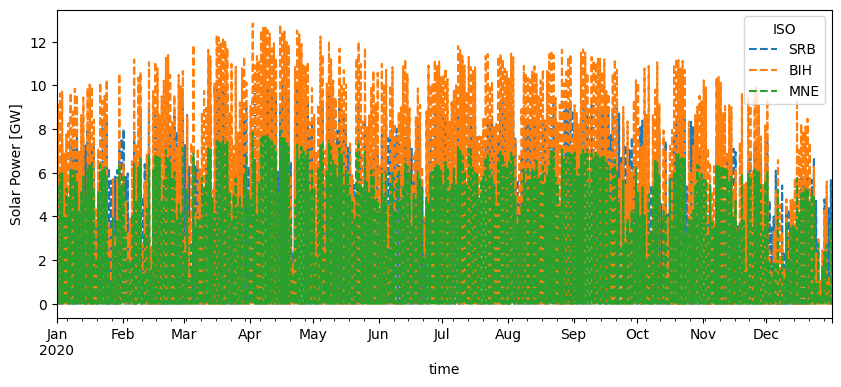

In [84]:
pv.to_pandas().div(1e3).plot(ylabel='Solar Power [GW]', ls='--', figsize=(10, 4))
plt.savefig('vis/Solar_Power_[GW]_2020.png', dpi=300)
pv.to_pandas().to_csv('data/solar_cf_2020.csv')

## Calculate WIND power

In [80]:
wind = cutout.wind(matrix=capacity_matrix, turbine='Siemens_SWT_2300kW',
               index=countries_gdf.index)

INFO:atlite.convert:Convert and aggregate 'wind'.


INFO:atlite.convert:Convert and aggregate 'wind'.


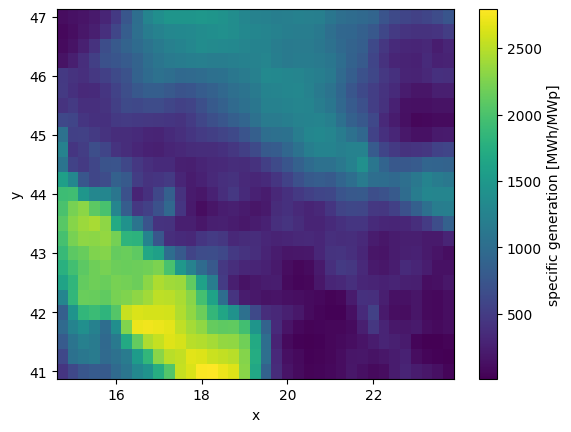

In [81]:
cutout.wind(turbine='Siemens_SWT_2300kW').plot()

In [85]:
wind

<xarray.DataArray 'specific generation' (time: 8784, ISO: 3)> Size: 211kB
array([[1702.35244611,  592.45668837,  438.77925707],
       [1494.62066863,  757.70126964,  482.73788597],
       [1265.89587764,  915.24328149,  427.06305472],
       ...,
       [ 529.70679284,   12.27155846,    0.        ],
       [ 371.07567264,   17.96639985,    0.        ],
       [ 235.48695856,   33.28629264,    0.        ]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
  * ISO      (ISO) object 24B 'SRB' 'BIH' 'MNE'
Attributes:
    units:    MW

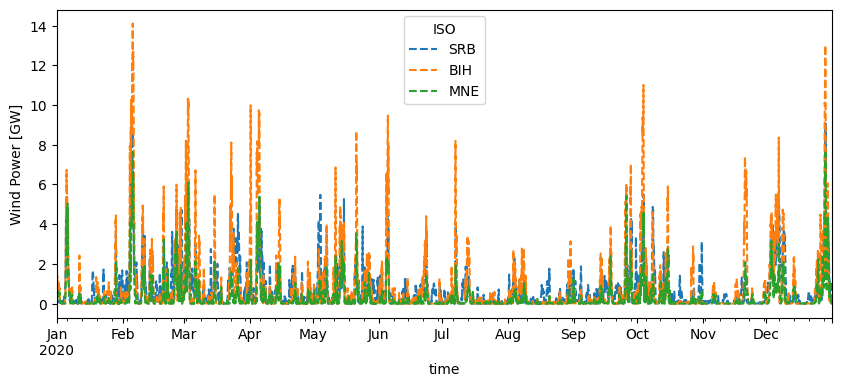

In [82]:
wind.to_pandas().div(1e3).plot(ylabel='Wind Power [GW]', ls='--', figsize=(10, 4))
plt.savefig('vis/Wind_Power_[GW]_2020.png', dpi=300)

In [83]:
wind.to_pandas().to_csv('data/wind_cf_2020.csv')